# Principal Componenet Analysis

In this notebook, we will take acoustic sounds from recordings of an acoustic guitar and apply principal component anlysis to identify the modes of each sound. 

By: Ryan McCarthy

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import librosa 
import librosa.display
import IPython.display as ipd

from glob import glob
import opendatasets as od 

In [3]:
od.download('https://www.kaggle.com/datasets/mehanat96/major-vs-minor-guitar-chords/data')

Dataset URL: https://www.kaggle.com/datasets/mehanat96/major-vs-minor-guitar-chords


100%|███████████████████████████████████████████████████████████████████████████████| 319M/319M [00:31<00:00, 10.5MB/s]


In [5]:
file = "major-vs-minor-guitar-chords/shords_dataset/major/1_10.wav"
data,sr = librosa.load(file)

In [7]:
# Play audio file
ipd.Audio(data=data,rate = sr)

In [211]:
files = glob("major-vs-minor-guitar-chords/shords_dataset/major/**/*.wav", recursive=True)

In [212]:
data,sr = librosa.load(files[0])

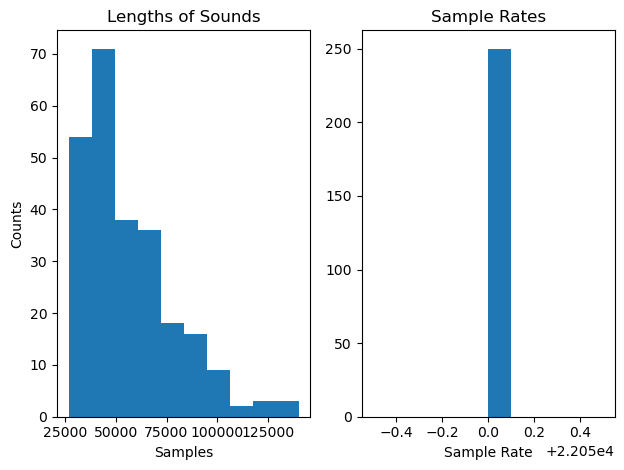

In [213]:
lens = []
srs = []
for f in files:
    data,sr = librosa.load(f)
    lens.append(len(data))
    srs.append(sr)
plt.subplot(1,2,1)
plt.hist(lens)
plt.title('Lengths of Sounds')
plt.xlabel('Samples')
plt.ylabel('Counts')
plt.subplot(1,2,2)
plt.hist(srs)
plt.title('Sample Rates')
plt.xlabel('Sample Rate')
plt.tight_layout()
plt.show()

In [214]:
print(f'Shortest Audio Length: {min(lens)}')
print(f'Sample Rate: {min(srs)}')

Shortest Audio Length: 26781
Sample Rate: 22050


In [215]:
Data = []
for f in files:
    data,sr = librosa.load(f)
    Data.append(data[0:min(lens)])
Data = np.vstack(Data)

In [216]:
d = Data[10,:]
ipd.Audio(data=d,rate = sr)

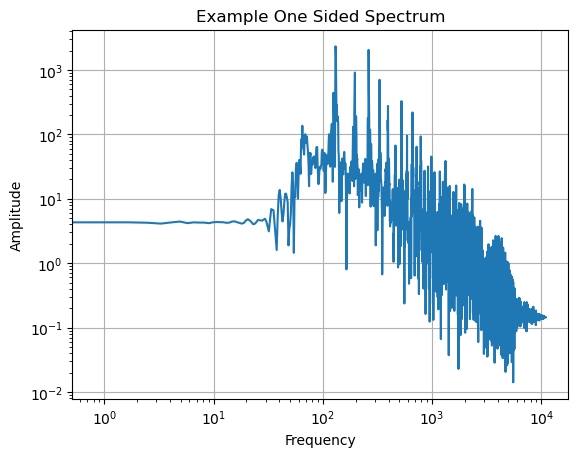

In [218]:
onesided = np.fft.rfft(d)
freq = np.fft.rfftfreq(len(d), d=1./sr)
plt.loglog(freq,abs(onesided))
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.title('Example One Sided Spectrum')
plt.grid()
plt.show()

In [219]:
from sklearn.decomposition import PCA

In [220]:
pca = PCA()
pca.fit(Data)

PCA()

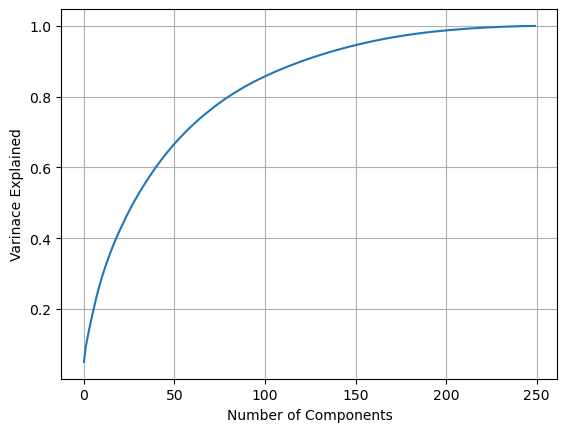

In [221]:
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_))
plt.ylabel("Varinace Explained")
plt.xlabel("Number of Components")
plt.grid()
plt.show()

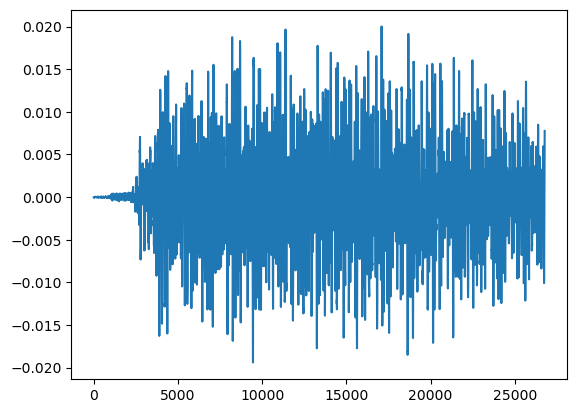

In [222]:
plt.plot(pca.components_[4,:])

In [223]:
ipd.Audio(data=pca.components_[0,:],rate = sr)

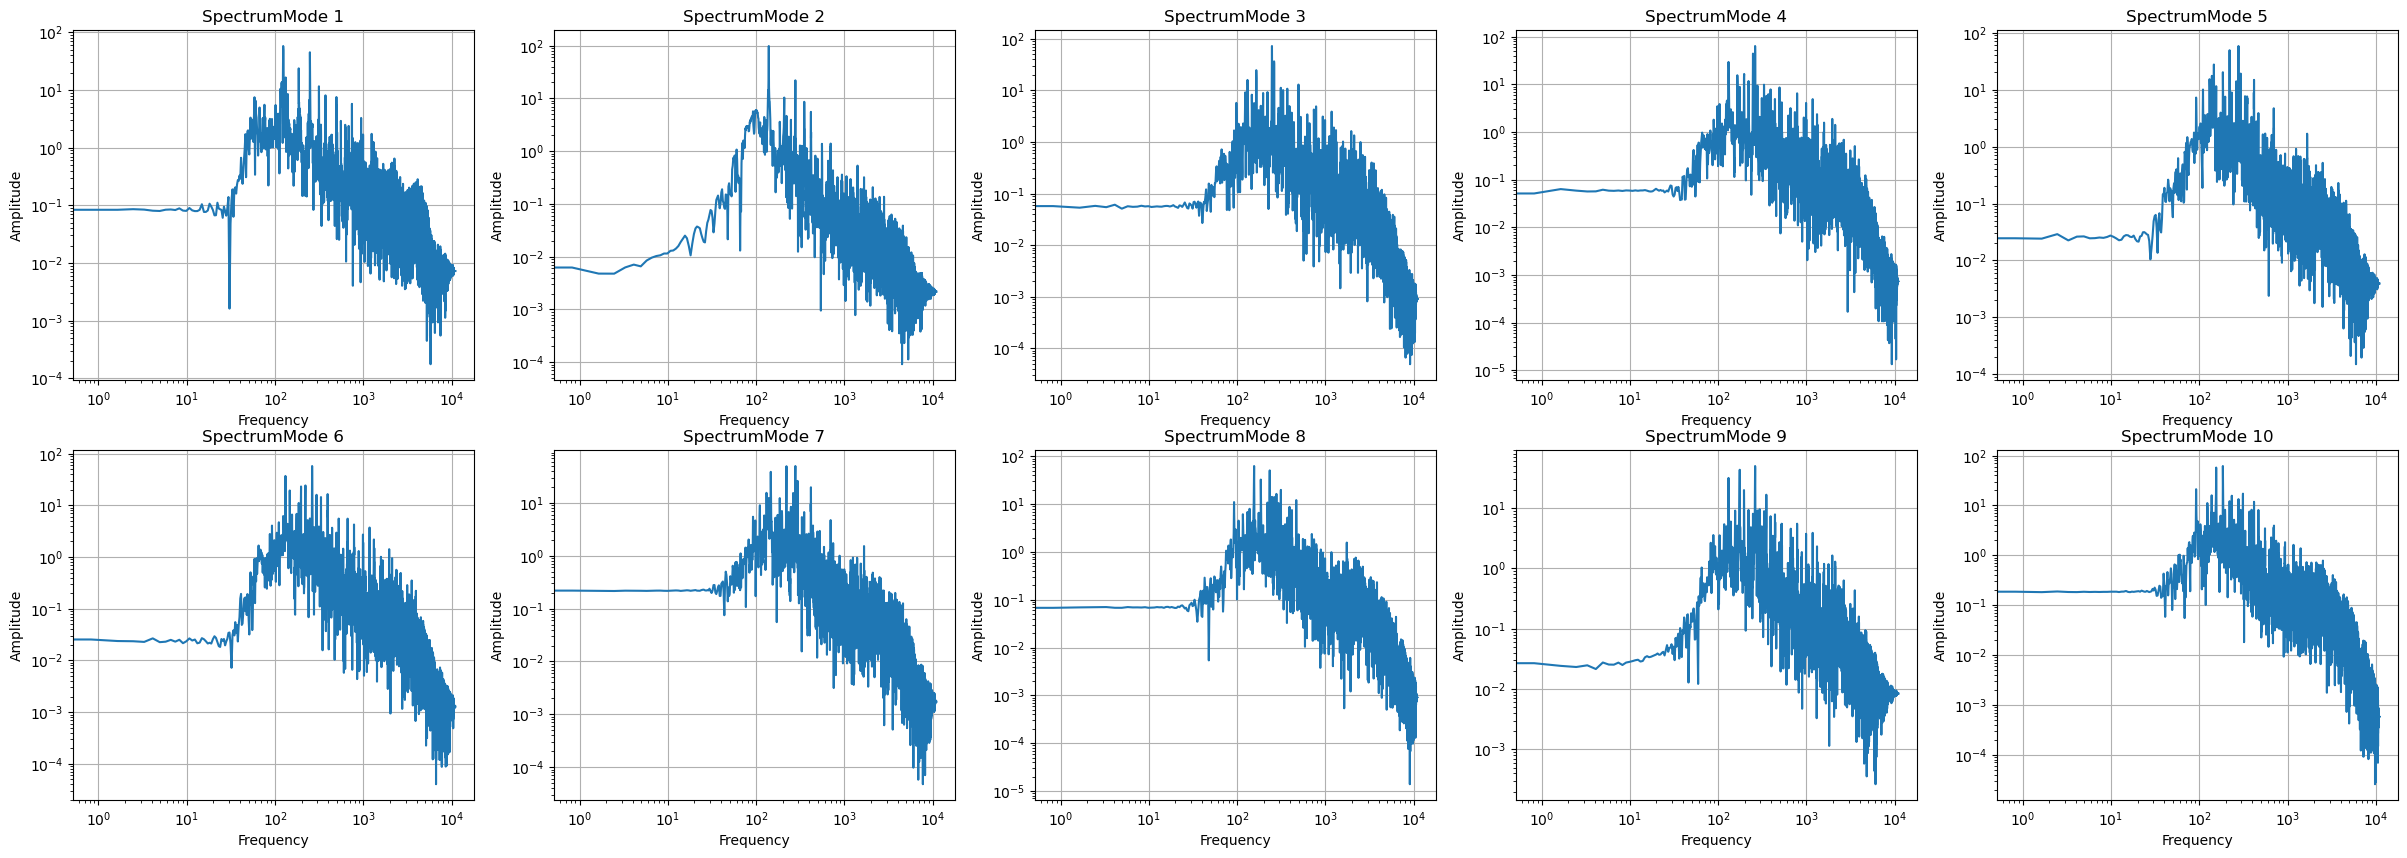

In [224]:
plt.figure(figsize = (30, 10))
ind = 1
for i in pca.components_[:10,:]:
    plt.subplot(2,5,ind)
    onesided = np.fft.rfft(i)
    freq = np.fft.rfftfreq(len(i), d=1./sr)
    plt.loglog(freq,abs(onesided))
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency')
    plt.title(f'SpectrumMode {ind}')
    plt.grid()
    ind += 1 
plt.show()
        

# Transforming the Data

In [225]:
nComp = 100
samplechoice = 0
Xhat = np.dot(pca.transform(Data[samplechoice,:].reshape(1,-1))[:,:nComp], pca.components_[:nComp,:])
Xhat += pca.mean_

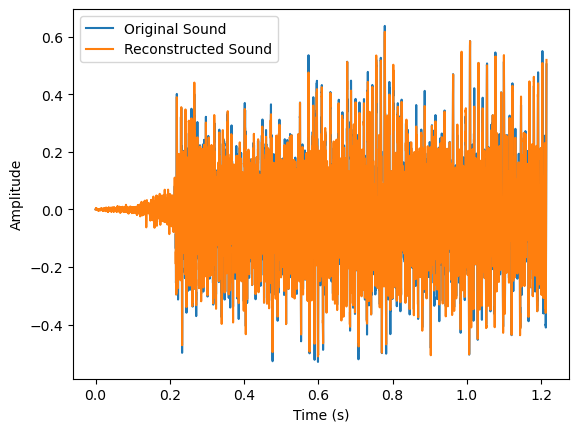

In [226]:
plt.plot(np.linspace(0,len(Data[samplechoice,:])/sr,len(Data[samplechoice,:])),Data[samplechoice,:])
plt.plot(np.linspace(0,len(Data[samplechoice,:])/sr,len(Data[samplechoice,:])),Xhat.T)
plt.legend(['Original Sound', 'Reconstructed Sound'])
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()

Original Guitar Sound

In [227]:
ipd.Audio(data=Data[samplechoice,:],rate = sr)

Reconstructed Guitar Sound

In [228]:
ipd.Audio(data=Xhat,rate = sr)

## Random Guitar Sound

In [229]:
from scipy.stats import norm

In [230]:
X_transformed = pca.transform(Data)

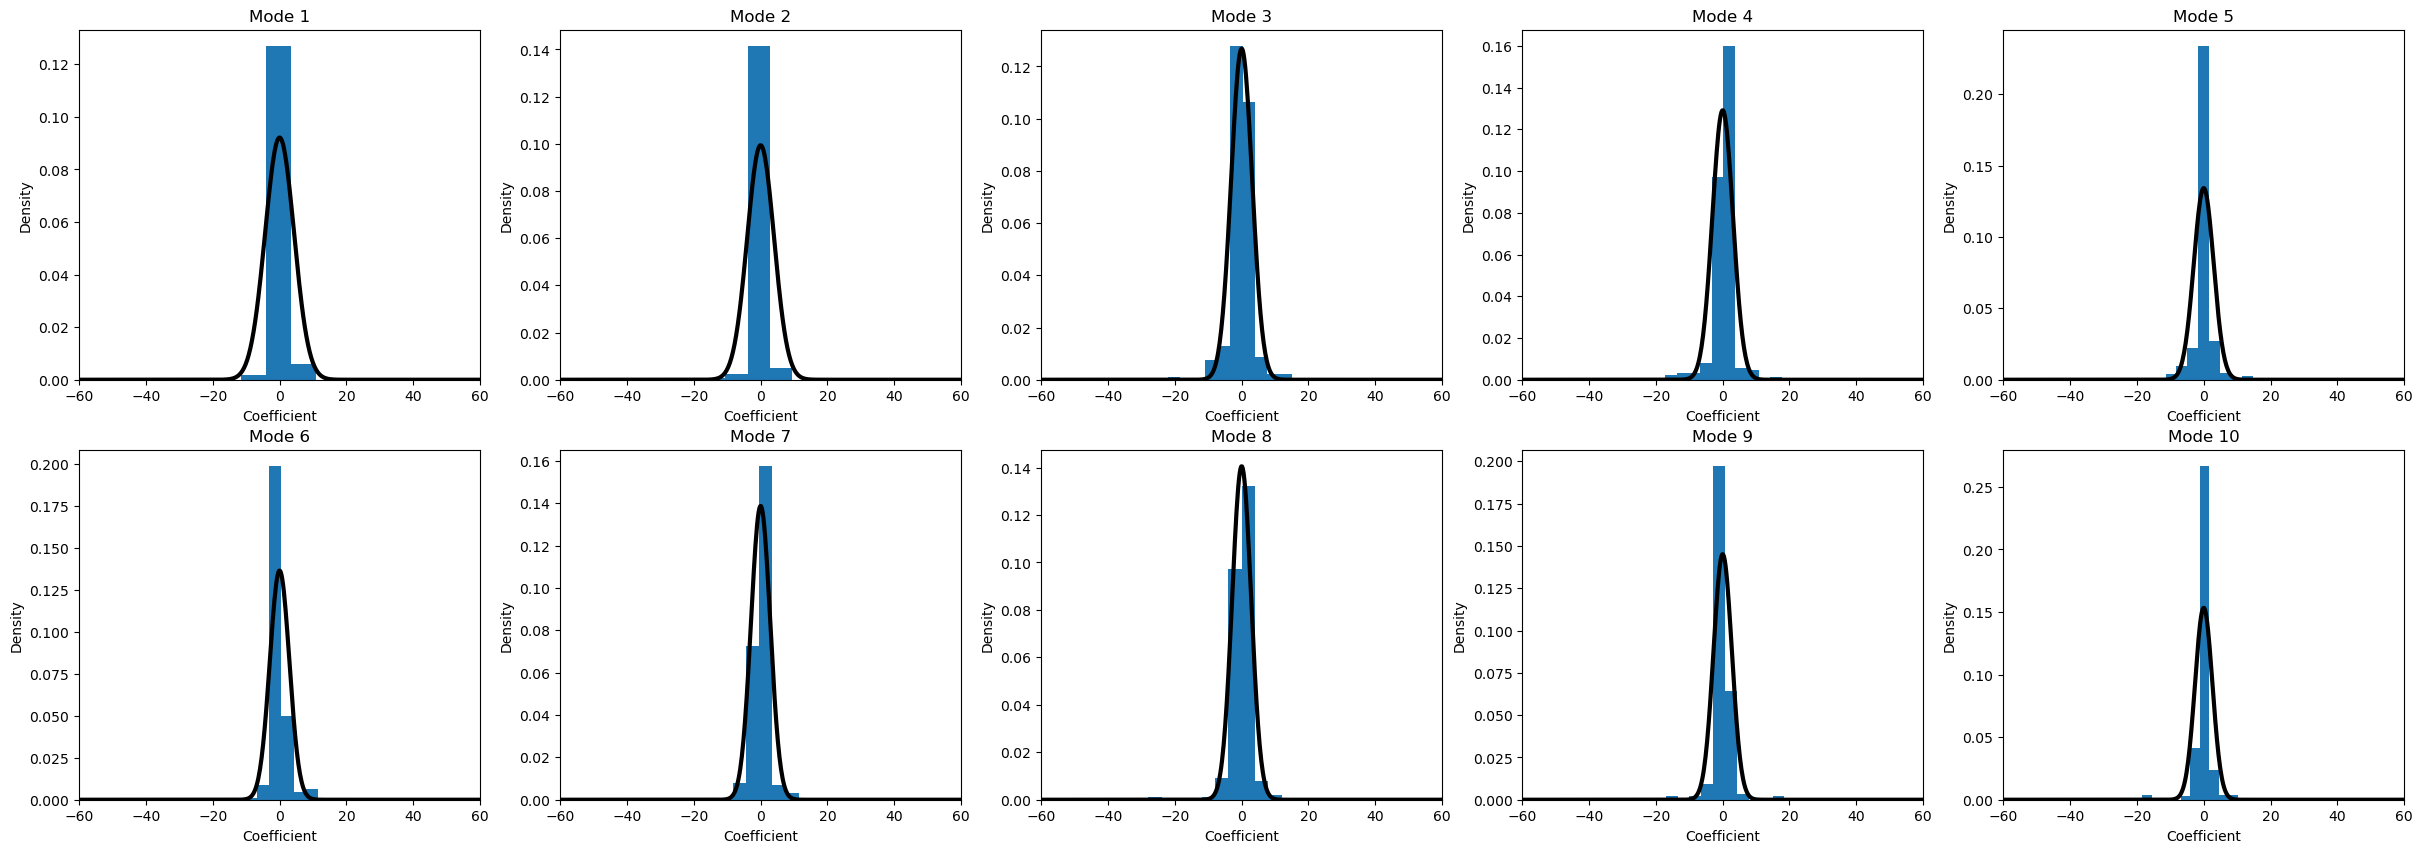

In [231]:
plt.figure(figsize = (30, 10))
ind = 1
for i in X_transformed[:,:10].T:
    plt.subplot(2,5,ind)
    plt.hist(i,density=True)
    plt.xlim(-60,60)
    mu, std = norm.fit(i)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, len(p))
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=3)
    plt.title(f'Mode {ind}')
    plt.ylabel('Density')
    plt.xlabel('Coefficient')
    ind +=1
plt.show()

In [235]:
randomchoice = []
for i in X_transformed[:,:nComp].T:
    mu, std = norm.fit(i)
    value = np.random.normal(mu, std)
    randomchoice.append(value)
randomchoice = np.array(randomchoice)

In [236]:
Xhat_random = np.dot(randomchoice.reshape(1,-1), pca.components_[:nComp,:])
Xhat_random += pca.mean_

In [237]:
ipd.Audio(data=Xhat_random,rate = sr)

We will transform the data using the ROCKET transform. This is a random kernel based transform that can pull out 2 feature components. Specifically, the max value from the kernel over the timeseries and the perecentage of positive values. We use 1000 kernels (2000 features extracted) in this example to demonstrate.

https://pypi.org/project/vmdpy/

In [ ]:
onesidedfeatures = []
for d in Data:
    onesidedfeatures.append(np.fft.rfft(d))
    
onesidedfeatures = np.vstack(onesidedfeatures)

# Citations